# Titanic5 - Improve Titanic4
### Remove multicategory (address overfitting)

# Feature Engineering

In [1]:
#Add features to better interpret data and see relationships better
###### Remove fare outliers and cluster fare to identify suitable fare groups,
###### which might indirectly tell / relate socio-economic class and potential cabin location / quality. (window / no window etc)

###### Group age groups into ranges

###### Identify potential family relation, family size, unaccompanied minor / teens
###### Split family name, group ticket / fares, embarkation

###### Impute missing age values and others, considering multiple features, e.g. embarkation, family relation, sibsp, parch etc

###### Check cabin is properly assigned; alpha only or alpha num


In [2]:
import pandas as pd
import numpy as np

In [3]:
titanic_raw_train = pd.read_csv("./titanic_data_raw/train.csv")
titanic_raw_test = pd.read_csv("./titanic_data_raw/test.csv")

In [4]:
titanic_raw_train['label'] = 'train'
titanic_raw_test['label'] = 'test'

In [5]:
titanic_raw_combined = pd.concat([titanic_raw_train, titanic_raw_test])

In [6]:
print("Length of df = ", len(titanic_raw_combined))
titanic_raw_combined.tail()

Length of df =  1309


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,label
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,test
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,test
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,test
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,test
417,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,test


### Add family name column

In [7]:
#create family name column
titanic_raw_combined["LastName"] = titanic_raw_combined["Name"].str.split(",", n=1, expand=True)[0]

### Add cabin info columns

In [8]:
# check cabin is properly assigned. Fill NaN cabin to 0 for proper processing.
titanic_raw_combined["Cabin"] = titanic_raw_combined["Cabin"].replace(np.nan,"not_assigned")
titanic_raw_combined["Cabin"] = titanic_raw_combined["Cabin"].astype(str)
titanic_raw_combined["cabin_proper"] = list(map(lambda x: (not x.isalpha()) & (x.strip().isalnum()), titanic_raw_combined['Cabin']))

In [9]:
titanic_raw_combined["multiple_cabin"] = list(map(lambda x: len(x)>1, titanic_raw_combined["Cabin"].str.split(" "))) 

### Impute Embarkation

In [10]:
impute_embarkation_df_full = titanic_raw_combined[['Fare', 'Ticket', 'Embarked', 'Pclass', 'SibSp', 'Parch','label']]

In [11]:
na_mask = impute_embarkation_df_full.isnull()
original = impute_embarkation_df_full
impute_embarkation_df_full = impute_embarkation_df_full[~na_mask]
impute_embarkation_df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Fare      1308 non-null   float64
 1   Ticket    1309 non-null   object 
 2   Embarked  1307 non-null   object 
 3   Pclass    1309 non-null   int64  
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   label     1309 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 81.8+ KB


In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

impute_embarkation_df_full['Ticket'] = le.fit_transform(impute_embarkation_df_full['Ticket'])
impute_embarkation_df_full['Embarked'] = le.fit_transform(impute_embarkation_df_full['Embarked'])

In [13]:
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

imputer_embarked = MissForest()
embarked_fit = imputer_embarked.fit(impute_embarkation_df_full[impute_embarkation_df_full['label']=='train'].drop('label', axis=1))

In [14]:
impute_embarkation_df_full = impute_embarkation_df_full.where(~na_mask, original)
impute_embarkation_df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Fare      1308 non-null   float64
 1   Ticket    1309 non-null   int32  
 2   Embarked  1307 non-null   object 
 3   Pclass    1309 non-null   int64  
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   label     1309 non-null   object 
dtypes: float64(1), int32(1), int64(3), object(2)
memory usage: 76.7+ KB


In [15]:
embarked_imputed = imputer_embarked.transform(impute_embarkation_df_full.drop('label', axis=1))

C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has b

Iteration: 0


C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has b

Iteration: 1


C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has b

Iteration: 2


C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has b

Iteration: 3


In [16]:
titanic_raw_combined['Embarked'] = le.inverse_transform(embarked_imputed[:, 2].round(0).astype('int64'))
titanic_raw_combined['Fare'] = embarked_imputed[:, 0]

### Add potential family relationship

In [17]:
#is potential family when they have the following in common
### same surname
### same embarkation
### same ticket
### same fare

titanic_raw_combined['family_number'] = titanic_raw_combined.groupby(['LastName', 'Ticket', 'Fare', 'Pclass', 'Embarked']).ngroup()

In [18]:
#count family member. greater than 1 means a family, one means single.
titanic_raw_combined['family_memb_count'] = titanic_raw_combined.groupby(['family_number'])['family_number'].transform('count')

In [19]:
titanic_raw_combined["has_family"] = list(map(lambda x: (x>1), titanic_raw_combined['family_memb_count']))

In [20]:
titanic_raw_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        1309 non-null   int64  
 1   Survived           891 non-null    float64
 2   Pclass             1309 non-null   int64  
 3   Name               1309 non-null   object 
 4   Sex                1309 non-null   object 
 5   Age                1046 non-null   float64
 6   SibSp              1309 non-null   int64  
 7   Parch              1309 non-null   int64  
 8   Ticket             1309 non-null   object 
 9   Fare               1309 non-null   float64
 10  Cabin              1309 non-null   object 
 11  Embarked           1309 non-null   object 
 12  label              1309 non-null   object 
 13  LastName           1309 non-null   object 
 14  cabin_proper       1309 non-null   bool   
 15  multiple_cabin     1309 non-null   bool   
 16  family_number      1309 n

### Add potential friendship

In [21]:
#is potential family when they have the following in common
### different surname
### same embarkation
### same ticket
### same fare

titanic_raw_combined['friend_number'] = titanic_raw_combined.groupby(['Ticket', 'Fare', 'Pclass', 'Embarked']).ngroup()
titanic_raw_combined['friends_count'] = titanic_raw_combined.groupby(['friend_number'])['family_number'].transform('count')
titanic_raw_combined['friends_count'] = titanic_raw_combined['friends_count'].replace(np.nan, 0)

In [22]:
has_friend_df = titanic_raw_combined[(titanic_raw_combined['friends_count']>1) & (titanic_raw_combined['has_family']==False)]
has_friend_df['has_friend'] = True 

C:\Users\Personal\AppData\Local\Temp\ipykernel_13880\1677190393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_friend_df['has_friend'] = True


In [23]:
has_friend_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,label,LastName,cabin_proper,multiple_cabin,family_number,family_memb_count,has_family,friend_number,friends_count,has_friend
2,75,1.0,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,...,train,Bing,False,False,88,1,False,105,8,True
3,170,0.0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,...,train,Ling,False,False,558,1,False,105,8,True
4,510,1.0,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,...,train,Lang,False,False,528,1,False,105,8,True
5,644,1.0,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,...,train,Foo,False,False,310,1,False,105,8,True
8,839,1.0,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,...,train,Chip,False,False,178,1,False,105,8,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,1264,NaN,1,"Ismay, Mr. Joseph Bruce",male,49.0,0,0,112058,0.0000,...,test,Ismay,False,True,446,1,False,19,2,True
375,1267,NaN,1,"Bowen, Miss. Grace Scott",female,45.0,0,0,PC 17608,262.3750,...,test,Bowen,False,False,108,1,False,826,7,True
390,1282,NaN,1,"Payne, Mr. Vivian Ponsonby",male,23.0,0,0,12749,93.5000,...,test,Payne,True,False,740,1,False,87,4,True
400,1292,NaN,1,"Bonnell, Miss. Caroline",female,30.0,0,0,36928,164.8667,...,test,Bonnell,True,False,99,1,False,627,4,True


In [24]:
titanic_raw_combined = titanic_raw_combined.merge(has_friend_df[['PassengerId','has_friend']], how='left', on='PassengerId')
titanic_raw_combined['has_friend'] = titanic_raw_combined['has_friend'].replace(np.nan, False)

In [25]:
titanic_raw_combined

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,label,LastName,cabin_proper,multiple_cabin,family_number,family_memb_count,has_family,friend_number,friends_count,has_friend
0,546,0.0,1,"Nicholson, Mr. Arthur Ernest",male,64.0,0,0,693,26.0000,...,train,Nicholson,False,False,678,1,False,687,1,False
1,873,0.0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,...,train,Carlsson,False,True,158,1,False,689,1,False
2,75,1.0,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,...,train,Bing,False,False,88,1,False,105,8,True
3,170,0.0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,...,train,Ling,False,False,558,1,False,105,8,True
4,510,1.0,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,...,train,Lang,False,False,528,1,False,105,8,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,...,test,Spector,False,False,884,1,False,713,1,False
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,...,test,Oliva y Ocana,True,False,707,1,False,836,3,True
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,...,test,Saether,False,False,826,1,False,875,1,False
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,...,test,Ware,False,False,966,1,False,580,1,False


In [26]:
len(titanic_raw_combined)

1309

### add no family / friends

In [27]:
titanic_raw_combined = titanic_raw_combined.assign(no_fam_friend = ~titanic_raw_combined.has_family & ~titanic_raw_combined.has_friend)

### drop columns that are not useful

In [28]:
titanic_raw_combined.drop(['family_number', 'friend_number'], axis=1, inplace=True)

### Add age group column

In [29]:
#fill null age considering nultiple factors

In [30]:
#check if miss or master in name
import re
titanic_raw_combined = titanic_raw_combined.assign(has_master_miss = titanic_raw_combined.Name.str.contains("master|miss", flags=re.IGNORECASE))

In [31]:
#create df for imputation
age_impute_df_full = titanic_raw_combined.drop(['PassengerId', 'Name', 'LastName', 'Survived'], axis=1)

In [32]:
age_impute_df_full.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,label,cabin_proper,multiple_cabin,family_memb_count,has_family,friends_count,has_friend,no_fam_friend,has_master_miss
0,1,male,64.0,0,0,693,26.0000,not_assigned,S,train,False,False,1,False,1,False,True,False
1,1,male,33.0,0,0,695,5.0000,B51 B53 B55,S,train,False,True,1,False,1,False,True,False
2,3,male,32.0,0,0,1601,56.4958,not_assigned,S,train,False,False,1,False,8,True,False,False
3,3,male,28.0,0,0,1601,56.4958,not_assigned,S,train,False,False,1,False,8,True,False,False
4,3,male,26.0,0,0,1601,56.4958,not_assigned,S,train,False,False,1,False,8,True,False,False


In [33]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

age_impute_df_full['Sex'] = le.fit_transform(age_impute_df_full['Sex'])
age_impute_df_full['Ticket'] = le.fit_transform(age_impute_df_full['Ticket'])
age_impute_df_full['Cabin'] = le.fit_transform(age_impute_df_full['Cabin'])
age_impute_df_full['Embarked'] = le.fit_transform(age_impute_df_full['Embarked'])

In [34]:
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

imputer = MissForest()
age_imputed_fit = imputer.fit(age_impute_df_full[age_impute_df_full['label']=='train'].drop('label', axis=1))

In [35]:
age_imputed = imputer.transform(age_impute_df_full.drop('label', axis=1))

C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Iteration: 0
Iteration: 1


C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has b

Iteration: 2
Iteration: 3


C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [36]:
len(age_imputed[:, 2])

1309

In [37]:
titanic_raw_combined['Age'] = age_imputed[:, 2]

In [38]:
#create age range dataframe for mapping
age_map = {"lower_limit":[0.0,3.00001,7.00001,14.00001,18.00001,25.00001,35.00001,45.00001,55.00001,65.00001,75.00001], 
           "upper_limit":[3.0,7.0,14.0,18.0,25.0,35.0,45.0,55.0,65.0,75.0,150.0]}

age_map_df = pd.DataFrame(data=age_map)
age_map_df.reset_index(inplace=True)
age_map_df=age_map_df.rename(columns={'index':'age_grp'}) 
age_map_df['age_grp'] = age_map_df['age_grp'].astype('category')
age_map_df.tail()

,age_grp,lower_limit,upper_limit
6,6,35.00001,45.0
7,7,45.00001,55.0
8,8,55.00001,65.0
9,9,65.00001,75.0
10,10,75.00001,150.0


In [39]:
#join the map to main df and retain only if age conditions match to get age_range group
titanic_raw_combined = titanic_raw_combined.merge(age_map_df, how="cross")

In [40]:
titanic_raw_combined = titanic_raw_combined[(titanic_raw_combined['Age']<=titanic_raw_combined['upper_limit']) & (titanic_raw_combined['Age']>=titanic_raw_combined['lower_limit'])]
titanic_raw_combined.drop(['lower_limit', 'upper_limit'], axis=1, inplace=True)

In [41]:
len(titanic_raw_combined)

1309

### Save as excel for review / analysis using pivot table

In [42]:
titanic_raw_combined.to_csv('./Titanic4/titanic_raw_combined_engineered.csv')

In [43]:
titanic_raw_combined.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,LastName,cabin_proper,multiple_cabin,family_memb_count,has_family,friends_count,has_friend,no_fam_friend,has_master_miss,age_grp
8,546,0.0,1,"Nicholson, Mr. Arthur Ernest",male,64.000000,0,0,693,26.0000,...,Nicholson,False,False,1,False,1,False,True,False,8
16,873,0.0,1,"Carlsson, Mr. Frans Olof",male,33.000000,0,0,695,5.0000,...,Carlsson,False,True,1,False,1,False,True,False,5
27,75,1.0,3,"Bing, Mr. Lee",male,32.000000,0,0,1601,56.4958,...,Bing,False,False,1,False,8,True,False,False,5
38,170,0.0,3,"Ling, Mr. Lee",male,28.000000,0,0,1601,56.4958,...,Ling,False,False,1,False,8,True,False,False,5
49,510,1.0,3,"Lang, Mr. Fang",male,26.000000,0,0,1601,56.4958,...,Lang,False,False,1,False,8,True,False,False,5
60,644,1.0,3,"Foo, Mr. Choong",male,29.390238,0,0,1601,56.4958,...,Foo,False,False,1,False,8,True,False,False,5
71,693,1.0,3,"Lam, Mr. Ali",male,30.820571,0,0,1601,56.4958,...,Lam,False,False,2,True,8,False,False,False,5
82,827,0.0,3,"Lam, Mr. Len",male,30.820571,0,0,1601,56.4958,...,Lam,False,False,2,True,8,False,False,False,5
93,839,1.0,3,"Chip, Mr. Chang",male,32.000000,0,0,1601,56.4958,...,Chip,False,False,1,False,8,True,False,False,5
104,427,1.0,2,"Clarke, Mrs. Charles V (Ada Maria Winfield)",female,28.000000,1,0,2003,26.0000,...,Clarke,False,False,2,True,2,False,False,False,5


In [44]:
# pls.stop() #stopping point for run all

# Separate Out Validation set

In [45]:
val_set_proportion = 0.25
val_set_count = len(titanic_raw_combined[titanic_raw_combined['label']=='train'])*val_set_proportion
val_set_index = titanic_raw_combined[titanic_raw_combined['label']=='train'].sample(int(val_set_count), random_state=123).index
titanic_raw_combined.loc[val_set_index, 'label'] = 'validation'

# Handle Multiple Collinearity

In [46]:
# identify PCA components
data_for_pca = ['SibSp', 'Parch', 'Fare', 'family_memb_count', 'friends_count']

In [47]:
from sklearn.preprocessing import StandardScaler
scaled_df = titanic_raw_combined[data_for_pca]
scaled_df = StandardScaler().fit_transform(scaled_df) # normalizing the features

In [48]:
from sklearn.decomposition import PCA
pca_model = PCA(0.95)
pca_df = pca_model.fit_transform(scaled_df)

In [49]:
pca_model.explained_variance_ratio_

array([0.64521723, 0.1868569 , 0.1244368 ])

In [50]:
pca_df = pd.DataFrame(pca_df)
pca_df

,0,1,2
0,-1.028620,0.085726,0.007615
1,-1.127227,-0.286866,0.054784
2,1.153042,1.115106,-0.288380
3,1.153042,1.115106,-0.288380
4,1.153042,1.115106,-0.288380
...,...,...,...
1304,-1.112906,-0.232752,0.047933
1305,-0.056938,1.696098,-0.243590
1306,-1.116662,-0.246946,0.049730
1307,-1.112906,-0.232752,0.047933


In [51]:
titanic_raw_combined = pd.concat([titanic_raw_combined.reset_index(), pca_df], axis=1).set_index('index')
titanic_raw_combined = titanic_raw_combined[titanic_raw_combined.columns.difference(data_for_pca)]
titanic_raw_combined.tail()

,0,1,2,Age,Cabin,Embarked,LastName,Name,PassengerId,Pclass,...,Survived,Ticket,age_grp,cabin_proper,has_family,has_friend,has_master_miss,label,multiple_cabin,no_fam_friend
index,,,,,,,,,,,,,,,,,,,,,
14349,-1.112906,-0.232752,0.047933,33.625000,not_assigned,S,Spector,"Spector, Mr. Woolf",1305,3,...,NaN,A.5. 3236,5,False,False,False,False,test,False,True
14361,-0.056938,1.696098,-0.243590,39.000000,C105,C,Oliva y Ocana,"Oliva y Ocana, Dona. Fermina",1306,1,...,NaN,PC 17758,6,True,False,True,False,test,False,False
14372,-1.116662,-0.246946,0.049730,38.500000,not_assigned,S,Saether,"Saether, Mr. Simon Sivertsen",1307,3,...,NaN,SOTON/O.Q. 3101262,6,False,False,False,False,test,False,True
14382,-1.112906,-0.232752,0.047933,32.705000,not_assigned,S,Ware,"Ware, Mr. Frederick",1308,3,...,NaN,359309,5,False,False,False,False,test,False,True
14389,1.157533,-0.508781,0.244984,3.340717,not_assigned,C,Peter,"Peter, Master. Michael J",1309,3,...,NaN,2668,1,False,True,False,True,test,False,False


# Introduce Multicategory Output

In [52]:
# titanic_raw_combined = titanic_raw_combined.assign(temp_surv=np.select([~titanic_raw_combined['Survived'].isnull()], [titanic_raw_combined['Sex']+titanic_raw_combined['Survived'].astype('str')], np.nan))

In [53]:
# titanic_raw_combined['Survived'] = titanic_raw_combined['temp_surv']
# titanic_raw_combined.drop('temp_surv', axis=1, inplace=True)

In [54]:
# weights_for_model = {
#     'male1.0': 50,
#     'female1.0': 1.0,
#     'male0.0': 1.0,
#     'female0.0': 30,
# }

In [55]:
weights_for_model = 'balanced'

# Model Data

In [56]:
model_data = titanic_raw_combined.drop(['PassengerId', 'Name', 'LastName', 'Age'], axis=1)

In [57]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

model_data['Sex'] = le.fit_transform(model_data['Sex'])
model_data['Ticket'] = le.fit_transform(model_data['Ticket'])
model_data['Cabin'] = le.fit_transform(model_data['Cabin'])
model_data['Embarked'] = le.fit_transform(model_data['Embarked'])
model_data['age_grp'] = le.fit_transform(model_data['age_grp'])

# Model Training

In [58]:
training_data = model_data[model_data['label']=='train'].drop('label', axis=1)

In [59]:
x_train = training_data.drop('Survived', axis=1)
y_train = training_data['Survived']

In [60]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669 entries, 8 to 9799
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   0                669 non-null    float64
 1   1                669 non-null    float64
 2   2                669 non-null    float64
 3   Cabin            669 non-null    int32  
 4   Embarked         669 non-null    int32  
 5   Pclass           669 non-null    int64  
 6   Sex              669 non-null    int32  
 7   Ticket           669 non-null    int32  
 8   age_grp          669 non-null    int64  
 9   cabin_proper     669 non-null    bool   
 10  has_family       669 non-null    bool   
 11  has_friend       669 non-null    bool   
 12  has_master_miss  669 non-null    bool   
 13  multiple_cabin   669 non-null    bool   
 14  no_fam_friend    669 non-null    bool   
dtypes: bool(6), float64(3), int32(4), int64(2)
memory usage: 45.7 KB


In [61]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, 
                            random_state = 42,
                           class_weight=weights_for_model)
# Train the model on training data
rf.fit(x_train, y_train);

C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [62]:
rf.class_weight

'balanced'

In [63]:
rf.classes_

array([0., 1.])

# Validation

In [64]:
val_data = model_data[model_data['label']=='validation'].drop('label', axis=1)
x_val = val_data.drop('Survived', axis=1)
y_val = val_data['Survived']

In [65]:
survival_val = rf.predict(x_val) #class pred
survival_val_proba = rf.predict_proba(x_val) #probability pred

C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### Output Accuracy Metrics - 4 classes w gender

In [66]:
from sklearn.metrics import precision_recall_fscore_support
class_output_metrics_w_gender = pd.DataFrame(precision_recall_fscore_support(y_val,survival_val,average=None), index=str.split('precision_recall_fscore_support', '_')).set_axis(rf.classes_, axis=1)
class_output_metrics_w_gender

,0.0,1.0
precision,0.830986,0.862500
recall,0.914729,0.741935
fscore,0.870849,0.797688
support,129.000000,93.000000


### Output Accuracy Metrics - 2 classes

In [79]:
# y_val_2_class = val_data['Survived'].str.slice(-3,).astype('float64').astype('int')
# survival_val_2_class = pd.Series(survival_val).str.slice(-3,).astype('float64').astype('int')

In [ ]:
# temp_proba = pd.DataFrame(survival_val_proba)
# temp_proba = temp_proba.assign(Not_Survived=temp_proba[0]+temp_proba[2])
# temp_proba = temp_proba.assign(Survived=temp_proba[1]+temp_proba[3])
# survival_val_2_class_proba = temp_proba.iloc[:,-2:]

In [ ]:
# from sklearn.metrics import precision_recall_fscore_support
# class_output_metrics_2_class = pd.DataFrame(precision_recall_fscore_support(y_val_2_class,survival_val_2_class,average=None), index=str.split('precision_recall_fscore_support', '_')).rename(columns={0:'Not_Survived',1:'Survived'})
# class_output_metrics_2_class

### ROC curve - 4 classes

C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


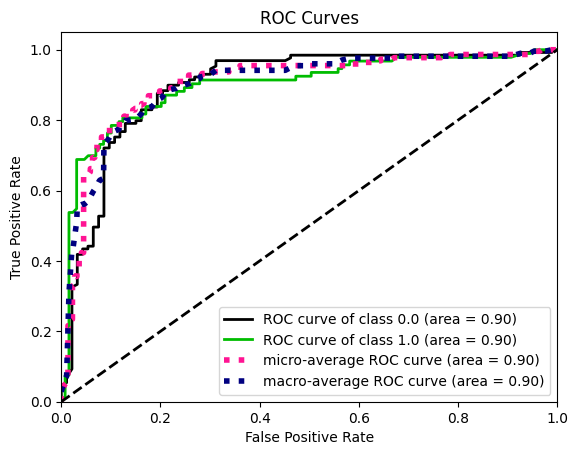

In [68]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc_curve(y_val, survival_val_proba)
plt.show()

### ROC curve - 2 classes

In [ ]:
# skplt.metrics.plot_roc_curve(y_val_2_class, survival_val_2_class_proba)
# plt.show()

In [ ]:
# pls.stop()

# Prediction

In [69]:
#test data
test_data = model_data[model_data['label']=='test'].drop('label', axis=1)
x_test = test_data.drop('Survived', axis=1)
survival_pred = rf.predict(x_test)

C:\Users\Personal\.conda\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [70]:
output_dataset = titanic_raw_combined[titanic_raw_combined['label']=='test'].drop('Survived', axis=1)

In [71]:
x_test['Survived'] = survival_pred

In [72]:
output_dataset = pd.concat([output_dataset, x_test], axis=1)

In [74]:
# output_dataset['Survived'] = output_dataset['Survived'].str.slice(-3,).astype('float64').astype('int')

In [77]:
surv_pred_submission = output_dataset[['PassengerId', 'Survived']].astype('float64').astype('int')
surv_pred_submission.to_csv('./Titanic5/titanic_5_submission.csv', index=False)

In [78]:
surv_pred_submission

,PassengerId,Survived
index,,
9806,892,0
9819,893,0
9831,894,0
9839,895,1
9849,896,0
...,...,...
14349,1305,0
14361,1306,1
14372,1307,0
